### 深度学习

深度学习是机器学习的一个类型，通常被定义为一种“表征学习”（Representation Learning）的方法。这个方法及其对应的模型，是直接从图像、文本或声音等非结构化数据（Unstructured Data）中学习执行分类任务。这类模型通常使用神经网络（Nerual Networks）架构为基础。之所以称为“深度”，是指神经网络中的层数，层数越多、网络越深。传统的神经网络只包含 2 层或 3 层，而深度网络可能多达几百层。

和前面文章中我们通过数理统计方法的建模，比如回归分析（Regression analysis）相比，深度学习建模通过多层处理，逐渐将初始的“低层”特征表示转化为“高层”特征表示后，用“简单模型”即可完成复杂的分类等学习任务。当前用的比较多的两类建模的方法分别为：循环神经网络（Recurrent Neural Network, RNN）和长短期记忆网络（LSTM，Long Short-Term Memory）。

### 循环神经网络

在传统的神经网络模型中，是从输入层到隐含层再到输出层，层与层之间是全连接的，每层之间的节点是无连接的。但是这种普通的神经网络对于很多问题却无能无力。例如，你要预测句子的下一个单词是什么，一般需要用到前面的单词，因为一个句子中前后单词并不是独立的，它们是有上下文关系的。RNN之所以称为循环神经网路，即一个序列当前的输出与前面的输出也有关。具体的表现形式为，网络会对前面的信息进行记忆、并应用于当前输出的计算中，即隐藏层之间的节点不再无连接而是有连接的。隐藏层的输入不仅包括输入层的输出还包括上一时刻隐藏层的输出。这样的描述听起来对时间序列数据分析很有帮助，因为我们之前的分析已经看到，个股的现价𝑥𝑡和前序价格𝑥(𝑡−ℎ)有显著的相关性，那么用循环神经网路对时间序列建模感觉就是顺理成章的事情。起码，是一定值得试下的，我们继续演示下如何操作。

首先，还是先导入几个python模块。除了之前用到的统计模块外，深度学习最主要的模块是基于深度学习框架tensorflow下的keras。

In [3]:
import akshare as ak
import numpy as np
import pandas as pd
import datetime
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, 
                                     Activation, Flatten, 
                                     MaxPooling2D, SimpleRNN)
from sklearn.model_selection import train_test_split
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

分别定义预测的次数=13，变量=1

In [5]:
n_steps=13
n_features=1

定义一个RNN的模型、以及神经元的数量等模型参数

In [9]:
model=Sequential()
model.add(SimpleRNN(512, activation='relu', 
                    input_shape=(n_steps, n_features),
                    return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [10]:
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['mse'])

In [11]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

简单看下日线的走势。

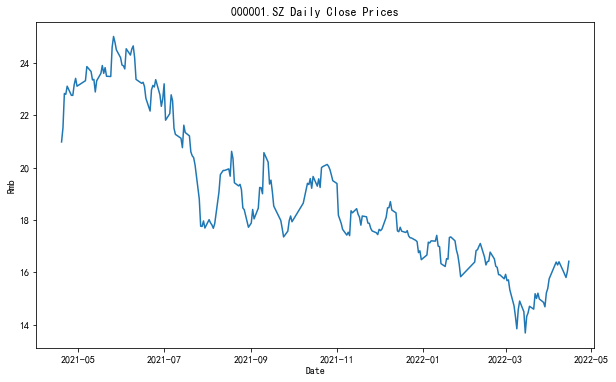

In [3]:
x=sz000001Daily.date
y=sz000001Close
plt.figure(figsize=(10, 6))
plt.plot(x,y)
plt.title('000001.SZ Daily Close Prices')
plt.ylabel('Rmb')
plt.xlabel('Date')
plt.show()

但基础走势图无法做进一步的描述性分析，需要将数据分解成长期趋势项、季节性周期项以及残差项几部分。用下面现成的函数就可以做到。

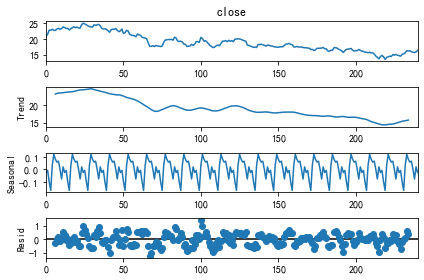

In [4]:
seasonal_decompose(sz000001Close, period=12).plot()
plt.show()

接着通过两个统计分析对时间序列进行分析，分别是：
* Autocroorelation Function 
* Partial Autocorrelation Function 

其中，Autocroorelation function（ACF）主要用来分析时间序列中的当前值和前序值之间的关系。因为在时间序列分析中，我们通常假设数据中的依赖结构不随时间变化。在这个假设下，影响协方差的唯一因素是两个时间序列中随机变量的距离 ，这个距离通常称为滞后lag，找到合适的lag很重要，是后续建模的基础。

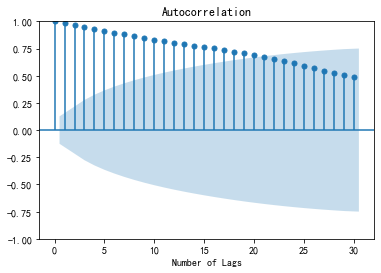

In [5]:
sm.graphics.tsa.plot_acf(sz000001Close, lags=30)
plt.xlabel('Number of Lags')
plt.show()

从上面这个图可以看出，平安银行股价的现价$x_t$和前序价格$x_(t-h)$有显著的相关性。因为第一根垂直线代表了当前值和自己的相关系数，为1，到$lag=15$的时候，我们看到相关系数也在0.75以上，而且这样的相关性衰减的也比较平缓。从这个统计结果上也佐证了平安银行股价，在过去的一年内是具有显著趋势的，比如，这里的下跌走势。

另一个用于分析时间序列相关性的统计函数是Partial autocorrelation function （PACF)，偏自相关函数描述的是一组时间序列和它前面间隔n个时刻的一组时间序列之前的偏相关性。这里的偏相关性可以从本质上理解为去除了样本之间的干涉，也就是更早时刻的相关性影响。我们用实际的数据看下效果。

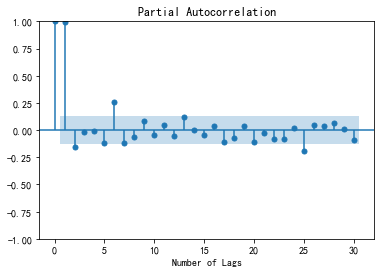

In [6]:
sm.graphics.tsa.plot_pacf(sz000001Close, lags=30)
plt.xlabel('Number of Lags')
plt.show()

这里主要看下极端值的情况，就是超过蓝色区域（置信区间）的值，上面显示出的为$lag=6$和$lag=25$。

### 平稳性分析

接着看下平稳性分析。我们说一个时间序列是平稳的，是指该时间序列的一系列统计属性，比如，均值、方差、协方差等并不随着时间而发生变化。之所以关注时间序列是否平稳，主要还是基于建模的考量。我们在做预测的时候，往往是假定该时间序列的数据是遵循某种统计分布的，比如：我们常用的正态分布。但如果数据的分布随着时间变化，我们就很难去建模和预测未来的结果。

所以，当市场出现结构性风险，比如金融危机、地缘战争、或者“新冠”疫情的时候，平稳性分析就显得更加重要，值得我们把数据看的更加仔细。平稳性又可以进一步划分为：弱平稳、和强平稳。具体定义的数学公式就不写了，我们重点关注看下如何做平稳性的统计分析。这里用到的统计分析是：Dickey-Fuller (ADF)测试。在95%的置信度区间下，我们看到目标个股的收盘价数据序列，是非平稳的。

In [7]:
statTest=adfuller(sz000001Close)[0:2]
print("The test statistic and p-value of ADF test are {}"
      .format(statTest))

The test statistic and p-value of ADF test are (-1.281067068919137, 0.6377890306118901)


通过取时间序列中的当前值和其前一个值的差，即：$x_t$和$x_t-1$的差可以平划数据里的非平稳性。感觉从下面这个图，可以看到数据是围绕某个均线在上下波动了。然后，我们再重新跑一遍ADF测试，看看$p$ value是不是显著。答案是，显著的，对应一个极低的值（3.5876828130207457e-12）。

In [8]:
diff_sz000001Close=sz000001Close.diff()

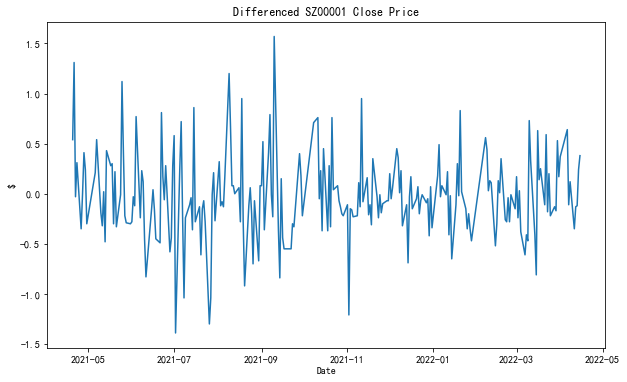

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(sz000001Daily.date,diff_sz000001Close)
plt.title('Differenced SZ00001 Close Price')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

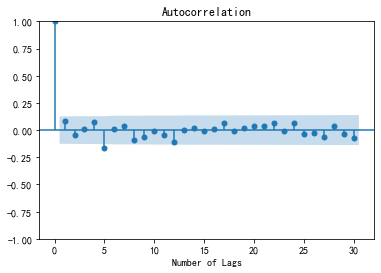

In [10]:
sm.graphics.tsa.plot_acf(diff_sz000001Close.dropna(),lags=30)
plt.xlabel('Number of Lags')
plt.show()

In [11]:
statTest2=adfuller(diff_sz000001Close.dropna())[0:2]
print("The test statistic and p-value of ADF test after differencing are {}"\
      .format(statTest2))

The test statistic and p-value of ADF test after differencing are (-7.626044383938417, 2.0674409027489904e-11)


### 移动平均模型

大部分炒股的人对Moving Average都不陌生，我们在任意炒股软件上看股票行情的时候，基本都默认有MA的趋势曲线。移动平均模型可以被理解为，通过对时间序列残值的滞后进行平滑处理形成的模型。这个表述比较拗口，我们用具体的例子来实践下。

根据之前的分析，大概的步骤是这样的。首先，我们把个股的收盘价数据下载下来，去掉缺失值，然后判断该收盘价曲线在平稳性分析上是否显著。接着，将所有的数据切分成训练集和测试集。

In [12]:
sz000001Close=sz000001Close.dropna()
statTest=adfuller(sz000001Close)[0:2]
print("The test statistic and p-value of ADF test are {}"
      .format(statTest))

The test statistic and p-value of ADF test are (-1.281067068919137, 0.6377890306118901)


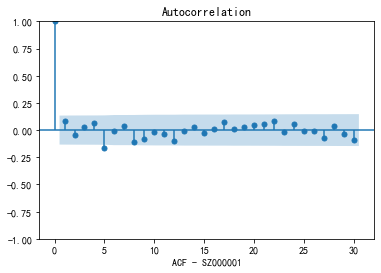

In [13]:
diff_sz000001Close=sz000001Close.diff().dropna()
split=int(len(diff_sz000001Close.values)*0.9)
diff_train_sz000001=diff_sz000001Close.iloc[:split]
diff_test_sz000001=diff_sz000001Close.iloc[split:]
sm.graphics.tsa.plot_acf(diff_train_sz000001,lags=30)
plt.xlabel('ACF - SZ000001')
plt.show()

上篇文章我们谈到，找到合适的滞后值lag很重要。通过上面这个图，根据超过蓝色置信区间的垂直线，我们就可以选择比较合适的滞后值，分别为short-term=5,long-term=12。

In [14]:
shortMA_sz000001=diff_train_sz000001.rolling(window=5).mean()
longMA_sz000001=diff_train_sz000001.rolling(window=12).mean()

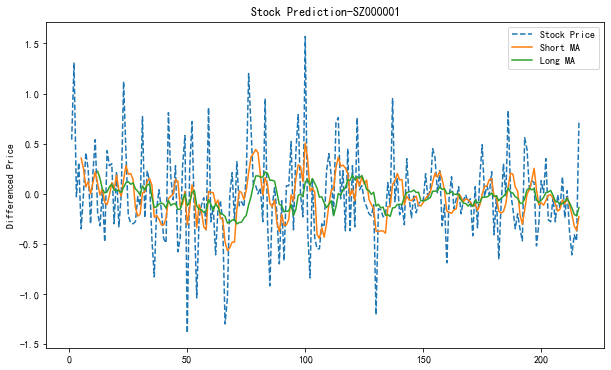

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(diff_train_sz000001,
        label='Stock Price', linestyle='--')
ax.plot(shortMA_sz000001,
        label = 'Short MA', linestyle='solid')
ax.plot(longMA_sz000001,
        label = 'Long MA', linestyle='solid')
ax.legend(loc='best')
ax.set_ylabel('Differenced Price')
ax.set_title('Stock Prediction-SZ000001')
plt.show()

从上面画图的结果可以看出，移动平均的窗口设为5的时候，模拟出的移动平均值更敏感，更接近真实的价差（当天-上一天）变化的趋势。而窗口设为12的时候，模拟出来的曲线更加平滑。但通过移动平均并不能达到预测的效果，Autocroorelation Function（ACF）的作图也是为了选择出较合适的平移窗口。<u>对我们的启发是，炒股软件上的MA功能是通用的模板，更科学的做法是基于个股的差异性找到最合适的平移窗口的设置</u>。这里我们就引出下一个模型：自回归模型。

### 自回归模型

自回归模型，即Autoregressive Model，是统计上一种处理时间序列的方法，用同一变数例如x的之前各期，亦即x1至xt-1来预测本期xt的表现，并假设它们为线性关系。因为这是从回归分析中的线性回归发展而来，只是不用x预测y，而是用x预测 x（自己）；所以叫做自回归。和我们经常使用的回归模型Regression Model相比，后者是研究一个变量（被解释变量）关于另一个（些）变量（解释变量）的依赖关系的方法。

自回归模型的优点是它需要的解释变量不多，因为它可用自身变数数列来进行预测。但是这种方法受到一定的限制：必须具有自相关。如果自相关系数(R)小于0.5，则不宜采用，否则预测结果极不准确。从前面我们对平安银行股价的现价$x_t$和前序价格$x_(t-h)$的分析看，有显著相关性的。

在AR模型中我们用Partial Autocorrelation Function，偏自相关函数去找到最合适的平移窗口。同时，为保证时间序列的平稳性，我们仍然使用的是差值，即：当前值和其前一个值的差。从下面画图的结果看，我们选择$lag=5$作为我们的最优窗口值。

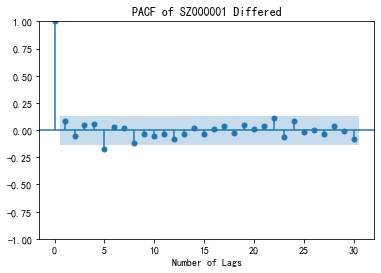

In [16]:
sm.graphics.tsa.plot_pacf(diff_train_sz000001, lags=30)
plt.title('PACF of SZ000001 Differed')
plt.xlabel('Number of Lags')
plt.show()

In [17]:
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')

In [18]:
ar_sz000001=AutoReg(diff_train_sz000001.values, lags=30)
ar_fitted_sz000001=ar_sz000001.fit()

In [19]:
ar_predictions_sz000001=ar_fitted_sz000001.predict(start=len(diff_train_sz000001), 
                                             end=len(diff_train_sz000001)\
                                             + len(diff_test_sz000001) - 1, 
                                             dynamic=False)

In [20]:
i=0
for i in range(len(ar_predictions_sz000001)):
    print('==' * 25)
    print('predicted values:{:.4f} & actual values:{:.4f}'\
          .format(ar_predictions_sz000001[i], diff_test_sz000001[split+i+1]))

predicted values:0.0453 & actual values:0.3300
predicted values:0.0941 & actual values:-0.4100
predicted values:0.1480 & actual values:-0.8100
predicted values:0.1028 & actual values:0.6300
predicted values:-0.0625 & actual values:0.1400
predicted values:0.0454 & actual values:0.2500
predicted values:-0.0676 & actual values:-0.1100
predicted values:-0.0826 & actual values:0.5900
predicted values:-0.0388 & actual values:-0.1800
predicted values:-0.0187 & actual values:0.2000
predicted values:-0.0928 & actual values:-0.2200
predicted values:-0.0627 & actual values:-0.1300
predicted values:-0.0772 & actual values:-0.1700
predicted values:-0.0653 & actual values:0.5300
predicted values:-0.1038 & actual values:0.1700
predicted values:-0.1983 & actual values:0.3700
predicted values:0.0545 & actual values:0.6400
predicted values:-0.1285 & actual values:-0.1100
predicted values:-0.0067 & actual values:0.1200
predicted values:-0.0312 & actual values:-0.3500
predicted values:-0.0734 & actual val

In [21]:
ar_predictions_sz000001=pd.DataFrame(ar_predictions_sz000001)
ar_predictions_sz000001.index=diff_test_sz000001.index

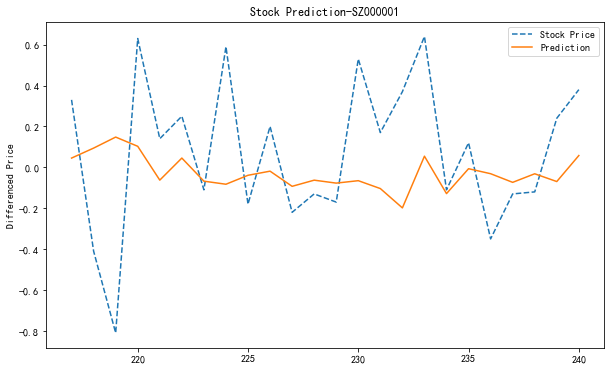

In [22]:
fig, ax=plt.subplots(figsize=(10, 6))
ax.plot(diff_test_sz000001,
        label='Stock Price', linestyle='--')
ax.plot(ar_predictions_sz000001,
        label='Prediction', linestyle='solid')
ax.legend(loc='best')
ax.set_ylabel('Differenced Price')
ax.set_title('Stock Prediction-SZ000001')
plt.show()

无论从之前的计算结果和可视化图表都可以看出，即使我们对时间序列做了平稳性调整后，通过AR做出的预测模型仍然是不可用的。接下来我们要继续尝试其它经典的模型，比如下面的：ARIMA模型（Autoregressive Integrated Moving Average model），差分整合移动平均自回归模型。

### 差分整合移动平均自回归模型

ARIMA模型时通过时间序列的历史值和其白噪音整合形成的模型。它可以被看作之前AR和MA模型的通用版本，只是后面两个模型适用的前提条件是平衡性。所以之前建模的时候，我们都是取了股票收盘价的变化值，并没有直接使用原始值。但在ARIMA模型中，我们可以通过对参数$d$的定义，而直接将股票收盘价的时间序列喂给模型训练。

事实上，在ARIMA模型的训练中，有3个核心参数需要设定，分别是$p$，$q$和$d$。前面两个参数分别是之前AR和MA模型训练时，我们用到的参数。参数$d$，也就是当差分阶数$d=0$时，ARIMA模型就等同于ARMA模型。即这两种模型的差别就是差分阶数d是否等于零，也就是时间序列是否平稳，ARIMA模型对应着非平稳时间序列， ARMA模型对应着平稳时间序列。为了能够直接处理原始时间序列，我们设定差分阶数$d=1$。下面我们通过对同一个股票的ARIMA模型训练，实际比较下和之前模型在准确率上差别。

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
split=int(len(sz000001Close.values)*0.9)
train_sz000001=sz000001Close.iloc[:split]
test_sz000001=sz000001Close.iloc[split:]

In [25]:
arima_sz000001=ARIMA(train_sz000001,order=(9,1,9))
arima_fit_sz000001=arima_sz000001.fit()

In [26]:
arima_predict_sz000001=arima_fit_sz000001.predict(start=len(train_sz000001), 
                                                  end=len(train_sz000001)\
                                                  + len(test_sz000001) - 1, 
                                                  dynamic=False)

In [27]:
arima_predict_sz000001=pd.DataFrame(arima_predict_sz000001)
arima_predict_sz000001.index=test_sz000001.index

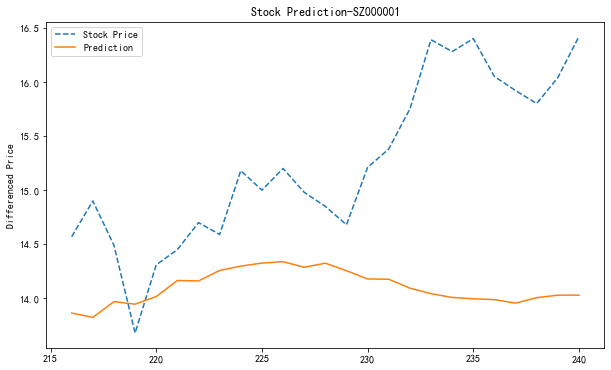

In [28]:
fig, ax=plt.subplots(figsize=(10, 6))
ax.plot(test_sz000001,
        label='Stock Price', linestyle='--')
ax.plot(arima_predict_sz000001,
        label='Prediction', linestyle='solid')
ax.legend(loc='best')
ax.set_ylabel('Differenced Price')
ax.set_title('Stock Prediction-SZ000001')
plt.show()

很显然，ARIMA模型并没有提升预测的准确性，其实涉及$p$，$q$和$d$3个参数的选择也是缺少理论依据的。找到最优的lag，即：滞后算子本身也不容易、且我们暂时也没找到特别好的方法，只能通过不断试不同的组合，找到最低的AIC值来决定最优的滞后算子。

In [29]:
import itertools

In [30]:
p=q= range(0, 9)
d=range(0, 3)
pdq=list(itertools.product(p,d,q))
arima_results_sz000001=[]
for param_set in pdq:
    try:
        arima_sz000001=ARIMA(train_sz000001,order=param_set)
        arima_fitted_sz000001=arima_sz000001.fit()
        arima_results_sz000001.append(arima_fitted_sz000001.aic)
    except:
        continue
print('**'*25)
print('The Lowest AIC score is {:.4f} and the corresponding parameters are {}'
      .format(pd.DataFrame(arima_results_sz000001)
             .where(pd.DataFrame(arima_results_sz000001).T.notnull().all()).min()[0], 
             pdq[arima_results_sz000001.index(min(arima_results_sz000001))]))

**************************************************
The Lowest AIC score is 247.1340 and the corresponding parameters are (2, 1, 2)


当我们将新的参数组合放到模型中重新顺利后，我们并没有发现模型的预测效果有显著的提升。具体的结果就不这这边展示了。